In [2]:
import numpy as np 
import pandas as pd

stock_symbol = '^GSPTSE' # MRK, PFE, XIC.TO, JNJ, ^GSPTSE

# ideally we want to automate this process for any index/stock, but for now we just use
#    a manually downloaded file from yahoo finance
raw_data = pd.read_csv('{}.csv'.format(stock_symbol)) # ^GSPTSE.csv, MRK.csv, PFE.csv
raw_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1979-06-29,1614.699951,1619.800049,1614.699951,1618.400024,1614.290161,0.0
1,1979-07-02,NaN,NaN,NaN,NaN,NaN,NaN
2,1979-07-03,1613.599976,1613.599976,1601.699951,1602.800049,1598.729736,0.0
3,1979-07-04,1601.500000,1601.500000,1589.500000,1591.400024,1587.358643,0.0
4,1979-07-05,1590.000000,1590.000000,1582.500000,1583.900024,1579.877808,0.0


In [3]:
date_close = raw_data.loc[:, ('Date', 'Adj Close')]
date_close

,Date,Adj Close
0,1979-06-29,1614.290161
1,1979-07-02,NaN
2,1979-07-03,1598.729736
3,1979-07-04,1587.358643
4,1979-07-05,1579.877808
...,...,...
11357,2023-09-25,19800.599609
11358,2023-09-26,19556.199219
11359,2023-09-27,19436.000000
11360,2023-09-28,19590.699219


In [4]:
cleaned = date_close.dropna() # removes any existing null values
cleaned

,Date,Adj Close
0,1979-06-29,1614.290161
2,1979-07-03,1598.729736
3,1979-07-04,1587.358643
4,1979-07-05,1579.877808
5,1979-07-06,1582.570923
...,...,...
11357,2023-09-25,19800.599609
11358,2023-09-26,19556.199219
11359,2023-09-27,19436.000000
11360,2023-09-28,19590.699219


We want a histogram of the % change in price, in buckets/bins.
First we need an array of all the % changes.

In [5]:
prices = cleaned.loc[:, 'Adj Close']
prices_array = prices.to_numpy()
row_count = len(prices_array) # range of our for loop

# ((prices_array[1] - prices_array[0]) / prices_array[0]) * 100

delta = []
for i in range(row_count - 1):
    percent_change = ((prices_array[i + 1] - prices_array[i]) / prices_array[i]) * 100
    delta.append(percent_change)

print(min(delta))
print(max(delta))

sorted_deltas = np.sort(delta)
print(sorted_deltas)

-12.344690347423914
11.957070036068938
[-12.34469035 -11.12655829 -10.26769586 ...   9.65583247   9.82328003
  11.95707004]


(array([1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        7.000e+00, 9.000e+00, 1.300e+01, 5.700e+01, 1.740e+02, 7.640e+02,
        4.060e+03, 4.958e+03, 8.650e+02, 1.320e+02, 3.500e+01, 1.300e+01,
        7.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00]),
 array([-13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
         -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
          9.,  10.,  11.,  12.]),
 <BarContainer object of 25 artists>)

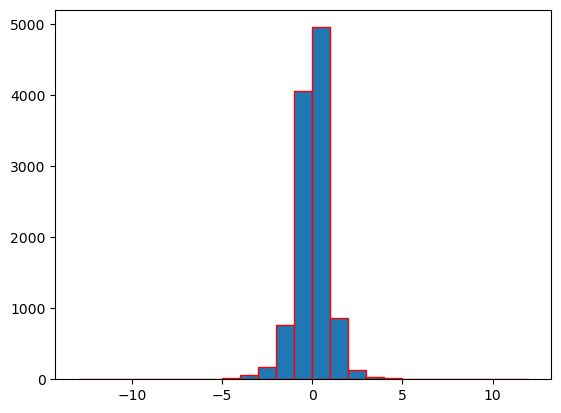

In [6]:
import matplotlib.pyplot as plt
import math

bins_min = math.floor(min(delta))
bins_max = math.ceil(max(delta))
bins_test = np.arange(bins_min, bins_max + 1) # (min - 1, max + 1)

plt.hist(sorted_deltas, edgecolor = 'red', bins = bins_test)

next steps:

- append delta array as column to 'cleaned' data frame, so we can correspond dates to major price changes
- find mean and standard deviation
- calculate z score for 95% of all values
- probability distribution of the deltas

In [7]:
delta_copy = delta.copy()
delta_copy.insert(0, None) # needed since there isnt a price change at the start
cleaned_copy = cleaned.copy()
cleaned_copy['Delta'] = delta_copy
cleaned_copy

,Date,Adj Close,Delta
0,1979-06-29,1614.290161,NaN
2,1979-07-03,1598.729736,-0.963917
3,1979-07-04,1587.358643,-0.711258
4,1979-07-05,1579.877808,-0.471276
5,1979-07-06,1582.570923,0.170463
...,...,...,...
11357,2023-09-25,19800.599609,0.104144
11358,2023-09-26,19556.199219,-1.234308
11359,2023-09-27,19436.000000,-0.614635
11360,2023-09-28,19590.699219,0.795942


In [8]:
# mean and variance, Z = ± 1.96?

delta_mean = sum(delta) / len(delta)
delta_variance = np.var(delta)
delta_sigma = math.sqrt(delta_variance)

print(delta_mean)
print(delta_variance)
print(delta_sigma)

0.02726811874856732
0.9592684995228627
0.9794225337018047


In [9]:
# Z = (x - u) / sigma
# x = u + (Z * sigma) 
# Z = ± 1.96

tails = np.array([-1.96, 1.96]) 
a = 14
normalized_bounds = delta_mean + tails.dot(delta_sigma)
print(normalized_bounds)

[-1.89240005  1.94693628]


find the % of data that is beyond these bounds

In [10]:
# sorted_deltas vs normalized_bounds

bound_counts = {
    'lower' : 0,
    'upper' : 0
}

for i in sorted_deltas:
    if i < normalized_bounds[0]:
        bound_counts['lower'] += 1
    elif i > normalized_bounds[1]:
        bound_counts['upper'] += 1
    else: 
        continue

print(bound_counts)

observation_count = len(sorted_deltas)

bound_percentages = {
    'lower' : 100 * (bound_counts['lower'] / observation_count),
    'upper' : 100 * (bound_counts['upper'] / observation_count)
}

print(bound_percentages)

{'lower': 309, 'upper': 205}
{'lower': 2.7810278102781028, 'upper': 1.8450184501845017}


In [11]:
delta_extremes = cleaned_copy.copy()
print(normalized_bounds)

extremes = [] #list of booleans to be appended to delta_extremes

for ind in delta_extremes.index:
    if ind == 0:
        extremes.append(None)
    elif delta_extremes['Delta'][ind] < normalized_bounds[0]:
        extremes.append('Negative Extreme')
    elif delta_extremes['Delta'][ind] > normalized_bounds[1]:
        extremes.append('Positive Extreme')
    else:
        extremes.append('Non-Extreme')

delta_extremes['Extremes'] = extremes
delta_extremes.head()
# we need to iterate over the rows, check delta cell and see if the value is outside of normalized_bounds
#   if so, mark it 1, 0 otherwise

[-1.89240005  1.94693628]


,Date,Adj Close,Delta,Extremes
0,1979-06-29,1614.290161,NaN,None
2,1979-07-03,1598.729736,-0.963917,Non-Extreme
3,1979-07-04,1587.358643,-0.711258,Non-Extreme
4,1979-07-05,1579.877808,-0.471276,Non-Extreme
5,1979-07-06,1582.570923,0.170463,Non-Extreme


In [12]:
# only need to do this step if dividends file exists

try:
    dividends = pd.read_csv('{}_dividends.csv'.format(stock_symbol))
    dividends_clean = dividends.dropna()
    # print(len(dividends_clean))

    cleaned_copy2 = cleaned.copy()
    # cleaned_copy2.head()

    dividend_frame = pd.merge(dividends_clean, cleaned_copy2, how = "inner")
    # dividend_frame.head()
    # merge dividends_clean with, cleaned dataframe
    print(dividend_frame)
except:
    print('This stock/index does not pay dividends.')


This stock/index does not pay dividends.


In [13]:
try: 
    dividends = pd.read_csv('{}_dividends.csv'.format(stock_symbol))

except:
    print('This stock/index does not pay dividends.')

else: 
    dividend_array = dividend_frame.loc[:, 'Dividends'].to_numpy()
    prices_array2 = dividend_frame.loc[:, 'Adj Close'].to_numpy()
    row_count2 = len(prices_array2)

    dividend_deltas = []
    for j in range(row_count2 - 1):
        dividend_delta = ((dividend_array[j + 1] + prices_array2[j + 1] - prices_array2[j])
                        / prices_array2[j]) * 100
        dividend_deltas.append(dividend_delta)

    dividend_deltas_copy = dividend_deltas.copy()
    dividend_deltas_copy.insert(0, None)
    dividend_returns = dividend_frame.copy()
    dividend_returns['Total Return Delta'] = dividend_deltas_copy
    # print(dividend_returns)

    dividend_delta_mean = sum(dividend_deltas) / len(dividend_deltas)
    print(dividend_delta_mean)
    dividend_delta_var = np.var(dividend_deltas)
    print(dividend_delta_var)
    dividend_delta_sigma = math.sqrt(dividend_delta_var)
    print(dividend_delta_sigma)
    print(tails)
    dividend_bounds = dividend_delta_mean + tails.dot(dividend_delta_sigma)
    print(dividend_bounds)

    dividend_extremes = dividend_returns.copy()
    extremes_sorted = []

    for j in dividend_extremes.index:  
        if j == 0:
              extremes_sorted.append(None)
        elif dividend_extremes['Total Return Delta'][j] < dividend_bounds[0]:
              extremes_sorted.append('Negative Extreme')
        elif dividend_extremes['Total Return Delta'][j] > dividend_bounds[1]:
              extremes_sorted.append('Positive Extreme')
        else:
              extremes_sorted.append('Non-Extreme')

    dividend_extremes['Extremes'] = extremes_sorted
    print(dividend_extremes)


This stock/index does not pay dividends.


In [14]:
try: 
    dividends = pd.read_csv('{}_dividends.csv'.format(stock_symbol))

except:
    print('This stock/index does not pay dividends.')

else: 
    dividend_min = math.floor(min(dividend_deltas))
    dividend_max = math.floor(max(dividend_deltas))
    dividend_bins = np.arange(dividend_min, dividend_max + 1)
    plt.hist(dividend_deltas, edgecolor = 'red', bins = dividend_bins)

    import statistics
    print(statistics.mean(dividend_deltas))

This stock/index does not pay dividends.


In [15]:
# dividend_extremes

In [16]:
delta_extremes

,Date,Adj Close,Delta,Extremes
0,1979-06-29,1614.290161,NaN,None
2,1979-07-03,1598.729736,-0.963917,Non-Extreme
3,1979-07-04,1587.358643,-0.711258,Non-Extreme
4,1979-07-05,1579.877808,-0.471276,Non-Extreme
5,1979-07-06,1582.570923,0.170463,Non-Extreme
...,...,...,...,...
11357,2023-09-25,19800.599609,0.104144,Non-Extreme
11358,2023-09-26,19556.199219,-1.234308,Non-Extreme
11359,2023-09-27,19436.000000,-0.614635,Non-Extreme
11360,2023-09-28,19590.699219,0.795942,Non-Extreme


In [17]:
import os

os.makedirs('/home/gabe-fabia/Documents/data-science/dataframes', exist_ok=True)
delta_extremes.to_csv('/home/gabe-fabia/Documents/data-science/dataframes/{}_delta_extremes.csv'.format(stock_symbol))
try: 
    dividends = pd.read_csv('{}_dividends.csv'.format(stock_symbol))

except:
    print('This stock/index does not pay dividends.')

else: 
    dividend_extremes.to_csv('/home/gabe-fabia/Documents/data-science/dataframes/{}_dividend_extremes.csv'.format(stock_symbol))

This stock/index does not pay dividends.
